In [141]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD

In [142]:
# For Not Displaying warnings
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

In [143]:
from pyxlsb import open_workbook as open_xlsb

In [144]:
# load the dataset.

df = []

with open_xlsb('WC_Data_Science_Case_Study.xlsb') as wb:
    with wb.get_sheet(1) as sheet:
        for row in sheet.rows():
            df.append([item.v for item in row])

df = pd.DataFrame(df[1:], columns=df[0])

df.head()

,Unique_ID,Case Number,Date of Birth,Accident State,Loss Type,Status_Updated,Loss Date,Closed Date,Report Date,Cause Description,Litigation,Occupation,Carrier,Sector/Industry,Claim Cost,High Cost
0,1.0,E8P0048,None,IN,Indemnity,Closed,42641.0,42704,42646,THE IW REPORTED HE WAS WALKING BACK TO FORK LI...,NO,None,Carrier 1,Industrials,13491.900269,0.0
1,2.0,E8P0649,None,IN,Indemnity,Open,42643.0,None,42654,"IE WAS GETTING OFF A FORKLIFT, FOOT SLIPPED AN...",NO,None,Carrier 1,Industrials,400921.536300,1.0
2,3.0,E9S0726,None,IN,Medical Only,Closed,42759.0,43106,42796,"IW WAS WALKING AROUND A SHEETING MACHINE, WHEN...",NO,None,Carrier 1,Industrials,4886.505400,0.0
3,4.0,E8P4445,None,IN,Medical Only,Closed,42703.0,42787,42706,"IW WAS HANDLING MATERIAL, CONFIRMING ORDER, IW...",NO,None,Carrier 1,Industrials,2506.715738,0.0
4,5.0,E7D4228,None,IN,Indemnity,Closed,42559.0,42784,42573,IW GOT FIBER GLASS DEBRIS IN EYE,NO,None,Carrier 1,Industrials,2916.488363,0.0


In [145]:
# list of column names.
df.columns

Index(['Unique_ID', 'Case Number', 'Date of Birth', 'Accident State',
       'Loss Type', 'Status_Updated', 'Loss Date', 'Closed Date',
       'Report Date', 'Cause Description', 'Litigation ', 'Occupation',
       'Carrier', 'Sector/Industry', 'Claim Cost', 'High Cost'],
      dtype='object')

In [146]:
# Shape of Data
df.shape

(57749, 16)

In [147]:
df['Occupation'].isnull().sum()

41333

In [148]:
# take out the 'Unique_ID' and 'Case Number' column.
# don't think they will be useful for my analysis.
df = df.drop(['Unique_ID', 'Case Number', 'Date of Birth', 'Occupation'], axis=1)

In [149]:
#Creating dataframe with number of missing values
missing_val = pd.DataFrame(df.isnull().sum())

#Reset the index to get row names as columns
missing_val = missing_val.reset_index()

#Rename the columns
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(df))*100

#Sort the rows according to decreasing missing percentage
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

#Save output to csv file
missing_val.to_csv("Missing_percentage.csv", index = False)

missing_val

,Variables,Missing_percentage
0,Litigation,28.059360
1,Closed Date,23.195207
2,Accident State,15.629708
3,Report Date,11.908431
4,Cause Description,1.634660
5,Loss Type,0.015585
6,Status_Updated,0.015585
7,Loss Date,0.015585
8,Carrier,0.015585
9,Sector/Industry,0.015585


In [150]:
df = df.rename(columns=lambda x: x.replace(' ', ''))

In [151]:
categorical_variables = ['LossType', 'Status_Updated','Litigation','Carrier', 'AccidentState','Sector/Industry', 'HighCost']

In [152]:
for col in categorical_variables:
    print("+++++++++++++++++++++++++++++++")
    print(col)
    print()
    print(df[col].value_counts())
    print()
    print("+++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++
LossType

Medical Only    32737
Indemnity       17814
Notice Only      7110
Unknown            79
Name: LossType, dtype: int64

+++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++
Status_Updated

Closed        44437
0.0            8718
Open           4111
Open            352
Closed          122
Name: Status_Updated, dtype: int64

+++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++
Litigation

NO     34406
No      4841
YES     1585
Yes      713
Name: Litigation, dtype: int64

+++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++
Carrier

              49936
Carrier 2      5170
Carrier 3       871
Carrier 7       684
Carrier 5       330
Carrier 4       298
Carrier 8       180
Carrier 11      115
Carrier 6        86
Carrier 1        54
Carrier 10        9
Carrier 9         7
Name: Carrier, dtype: int64

+++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++
AccidentState

CA              9123
FL              3976
C

In [153]:
description_text = pd.DataFrame(df['CauseDescription'].fillna(''))

In [154]:
for col in categorical_variables:
    print(col)
    description_text[col] = df[col]

LossType
Status_Updated
Litigation
Carrier
AccidentState
Sector/Industry
HighCost


In [155]:
description_text.isnull().sum()

CauseDescription        0
LossType                9
Status_Updated          9
Litigation          16204
Carrier                 9
AccidentState        9026
Sector/Industry         9
HighCost                9
dtype: int64

In [156]:
for col in categorical_variables:
    if description_text[col].isnull().sum() != 0:
        description_text[col] = description_text[col].fillna(description_text[col].mode()[0])
        

In [157]:
description_text.isnull().sum()

CauseDescription    0
LossType            0
Status_Updated      0
Litigation          0
Carrier             0
AccidentState       0
Sector/Industry     0
HighCost            0
dtype: int64

In [158]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [159]:
from nltk.corpus import stopwords
from string import punctuation
from bs4 import BeautifulSoup 
import re

stop_words = set(stopwords.words('english')) 
stopwords_en_withpunct = stop_words.union(set(punctuation))

def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stopwords_en_withpunct]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()


In [160]:
description_text['cleaned_description'] = description_text.CauseDescription.apply(text_cleaner)

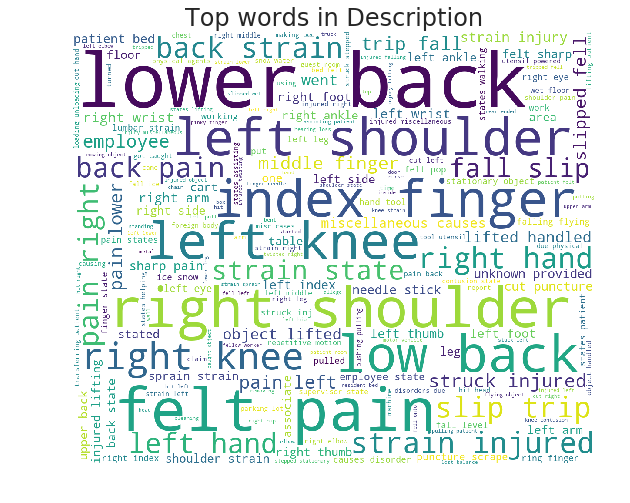

In [161]:
from wordcloud import WordCloud
plt.figure(figsize = (12, 8))
text = ' '.join(description_text['cleaned_description'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Description')
plt.axis("off")
plt.show()

In [162]:
# Converting all datatypes
description_text.Litigation.value_counts()

NO     50610
No      4841
YES     1585
Yes      713
Name: Litigation, dtype: int64

In [163]:
description_text['Litigation'] = description_text['Litigation'].replace(["YES", "Yes"], 1)
description_text['Litigation'] = description_text['Litigation'].replace(["NO", "No"], 0)

In [164]:
description_text.Litigation.value_counts()

0    55451
1     2298
Name: Litigation, dtype: int64

In [165]:
description_text.Status_Updated.unique()

array(['Closed', 'Open', 'Closed    ', 'Open ', 0.0], dtype=object)

In [166]:
description_text['Status_Updated'] = description_text['Status_Updated'].replace(["Closed", "Closed    ",0.0], 0)
description_text['Status_Updated'] = description_text['Status_Updated'].replace(["Open", "Open "], 1)

In [167]:
description_text.Status_Updated.value_counts()

0    53286
1     4463
Name: Status_Updated, dtype: int64

In [168]:
description_text.Carrier.unique()

array(['Carrier 1', 'Carrier 2', 'Carrier 3', 'Carrier 4', 'Carrier 5',
       'Carrier 6', '', 'Carrier 7', 'Carrier 8', 'Carrier 9',
       'Carrier 10', 'Carrier 11'], dtype=object)

In [169]:
description_text['Carrier'] = description_text['Carrier'].apply(lambda x: x.replace('Carrier ', ''))

In [170]:
description_text.Carrier.value_counts()

      49945
2      5170
3       871
7       684
5       330
4       298
8       180
11      115
6        86
1        54
10        9
9         7
Name: Carrier, dtype: int64

In [171]:
description_text['Sector/Industry'].unique()

array(['Industrials', 'Consumer Disc', 'Health Care', 'Aviation ',
       'Consumer Staples', 'Information Technology',
       'Communication Services', 'Materials'], dtype=object)

In [172]:
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Industrials"], "ID")
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Consumer Disc"], "CD")
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Health Care"], "HC")
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Aviation "], "AV")
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Consumer Staples"], "CST")
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Information Technology"], "IT")
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Materials"], "MT")
description_text['Sector/Industry'] = description_text['Sector/Industry'].replace(["Communication Services"], "CSV")

In [173]:
description_text['Sector/Industry'].unique()

array(['ID', 'CD', 'HC', 'AV', 'CST', 'IT', 'CSV', 'MT'], dtype=object)

In [174]:
# # wordcloud for Cases with Litigation 0

Litigation_0_df = description_text.loc[description_text['Litigation'] == 0]
Litigation_0_df.head()

Litigation_0_df['cleaned_description'] = Litigation_0_df.CauseDescription.apply(text_cleaner)

In [175]:
description_text.Litigation.value_counts()

0    55451
1     2298
Name: Litigation, dtype: int64

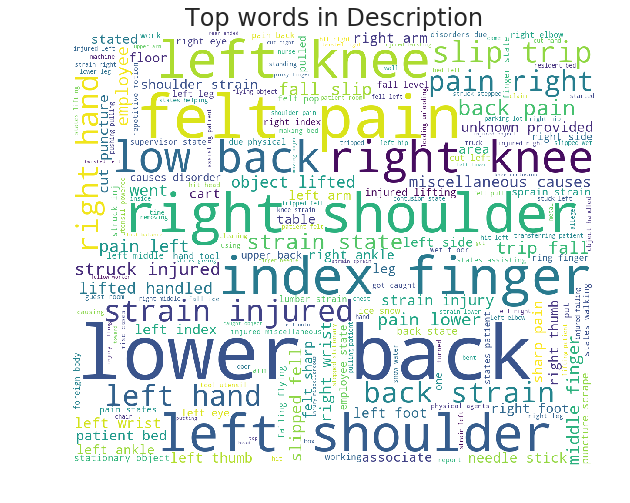

In [176]:
plt.figure(figsize = (12, 8))
text = ' '.join(Litigation_0_df['cleaned_description'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Description')
plt.axis("off")
plt.show()

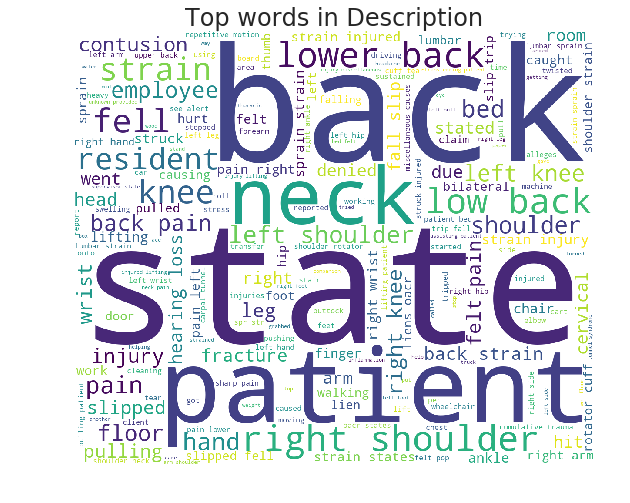

In [177]:
# # wordcloud for Cases with Litigation 1

Litigation_1_df = description_text.loc[description_text['Litigation'] == 1]
Litigation_1_df.head()

Litigation_1_df['cleaned_description'] = Litigation_1_df.CauseDescription.apply(text_cleaner)

plt.figure(figsize = (12, 8))
text = ' '.join(Litigation_1_df['cleaned_description'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Description')
plt.axis("off")
plt.show()

In [178]:
import string
## Number of words in the CauseDescription ##
description_text["Desc_num_words"] = description_text["CauseDescription"].apply(lambda x: len(str(x).split()))

## Number of unique words in the CauseDescription ##
description_text["Desc_num_unique_words"] = description_text["CauseDescription"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the CauseDescription ##
description_text["Desc_num_chars"] = description_text["CauseDescription"].apply(lambda x: len(str(x)))

## Number of stopwords in the CauseDescription ##
description_text["Desc_num_stopwords"] = description_text["CauseDescription"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

## Number of punctuations in the CauseDescription ##
description_text["Desc_num_punctuations"] =description_text['CauseDescription'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of Upper case words in the CauseDescription ##
description_text["Desc_num_words_upper"] = description_text["CauseDescription"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of Title case words in the CauseDescription ##
description_text["Desc_num_words_CauseDescription"] = description_text["CauseDescription"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the CauseDescription ##
description_text["mean_word_len"] = description_text["CauseDescription"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


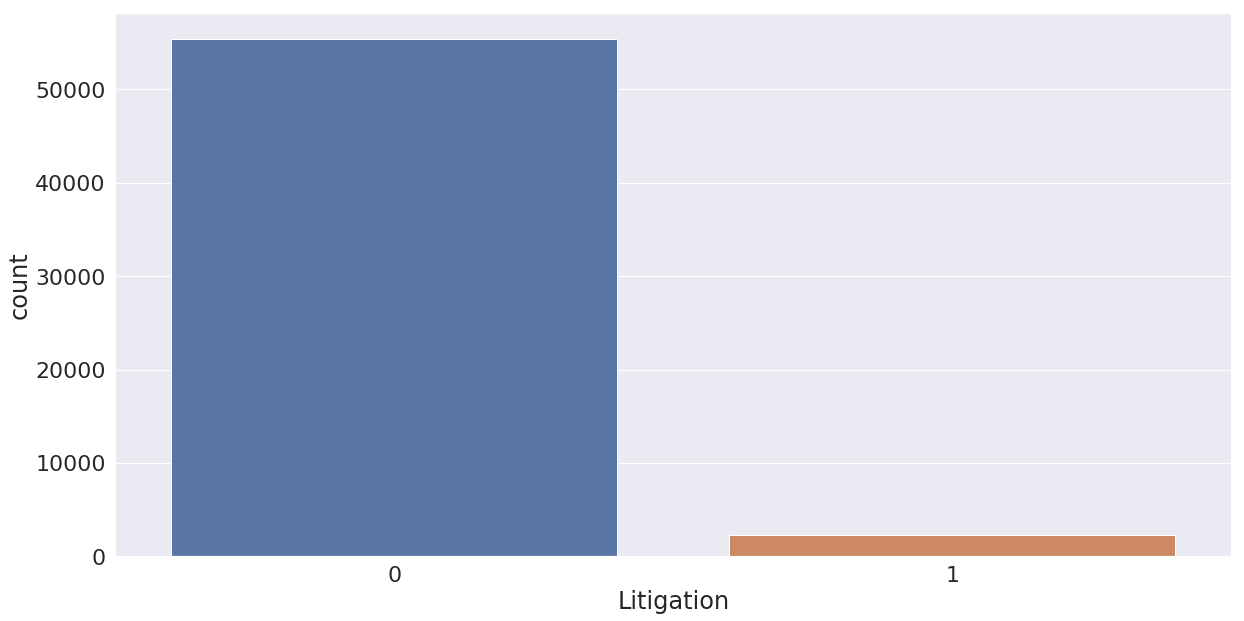

In [179]:
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
sns.countplot(description_text.Litigation)

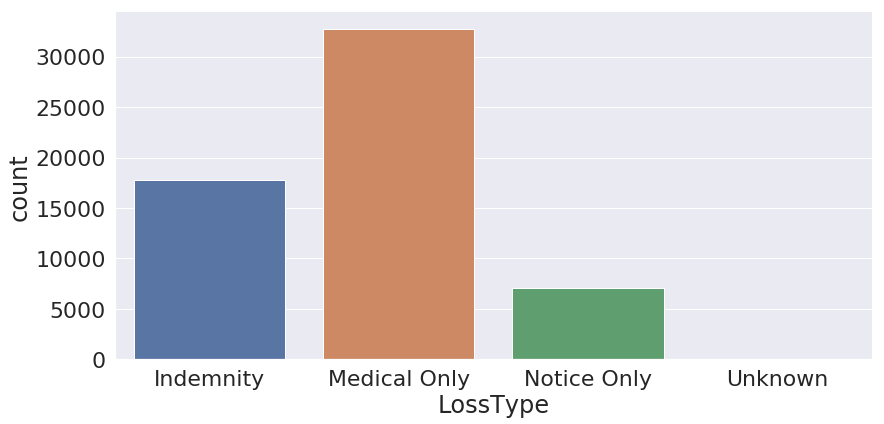

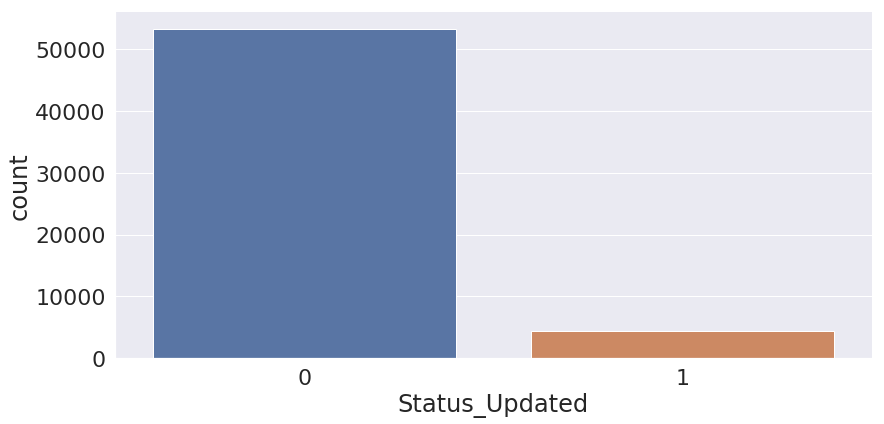

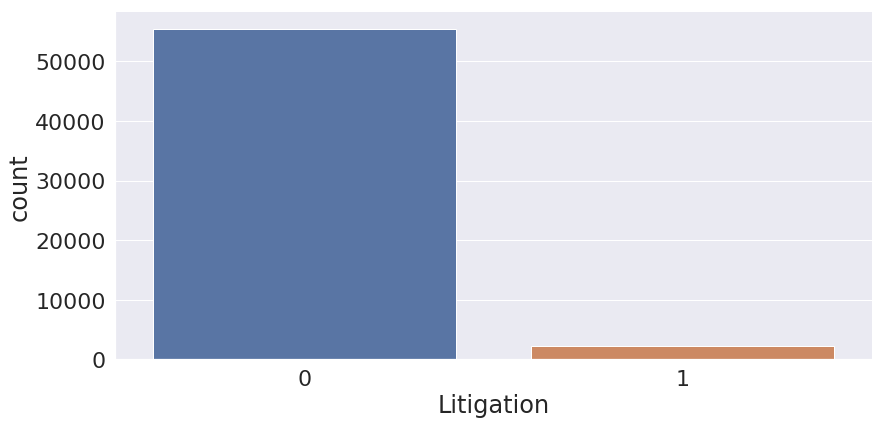

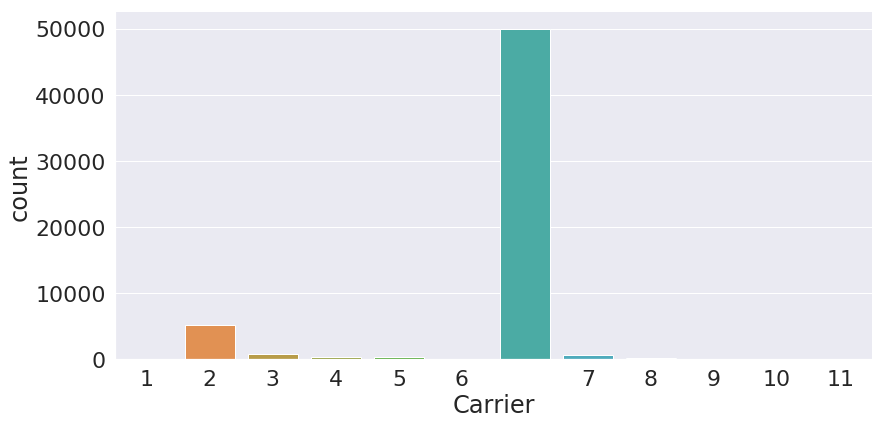

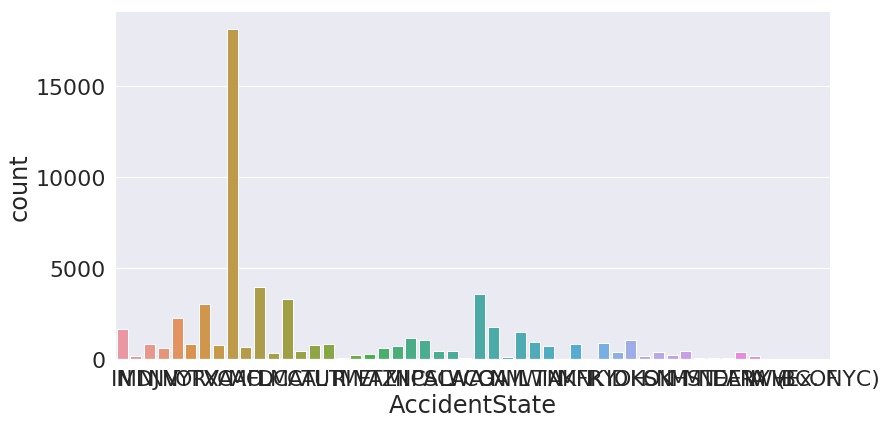

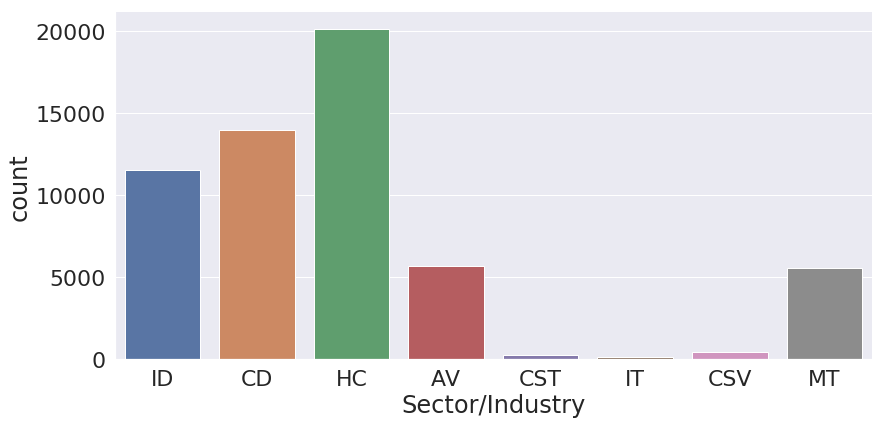

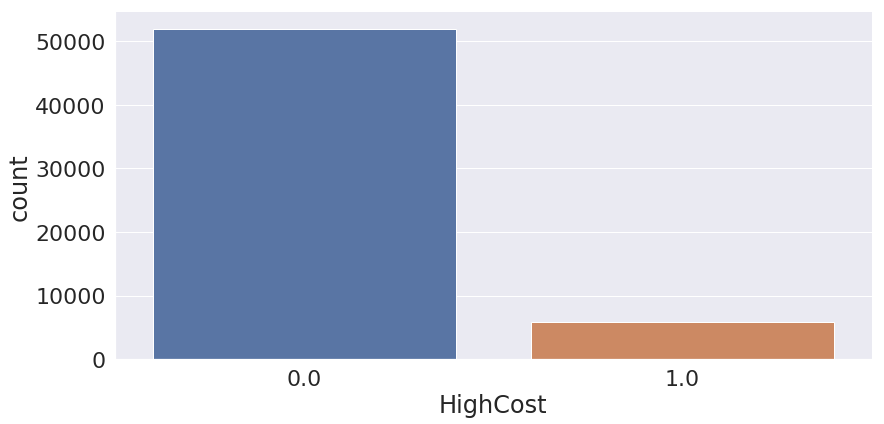

In [180]:
# Frequency Countplot for Categorical variable
%matplotlib inline

# factorplot for all categorical variables
for i in categorical_variables:
    sns.factorplot(data=description_text, x=i ,kind='count', size=6, aspect=2)

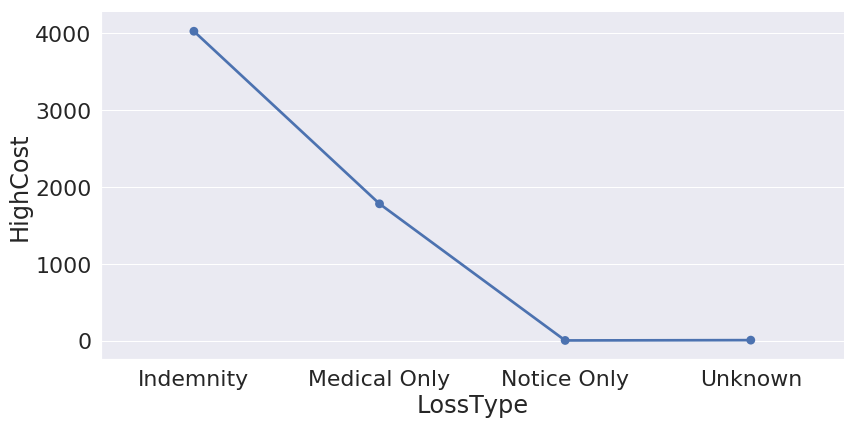

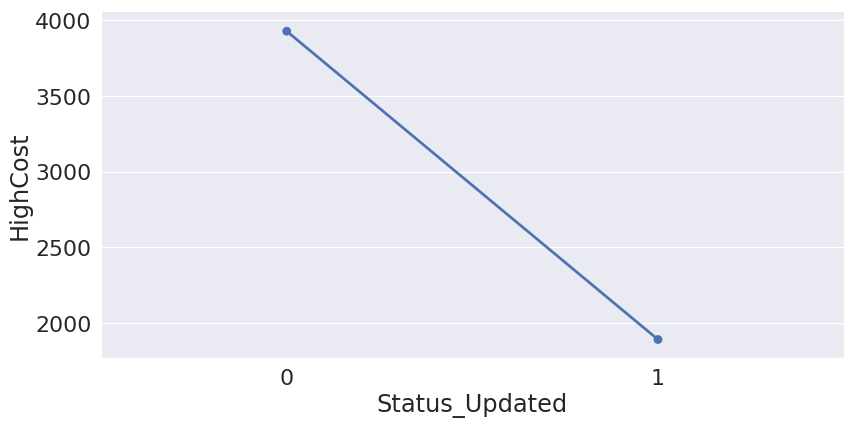

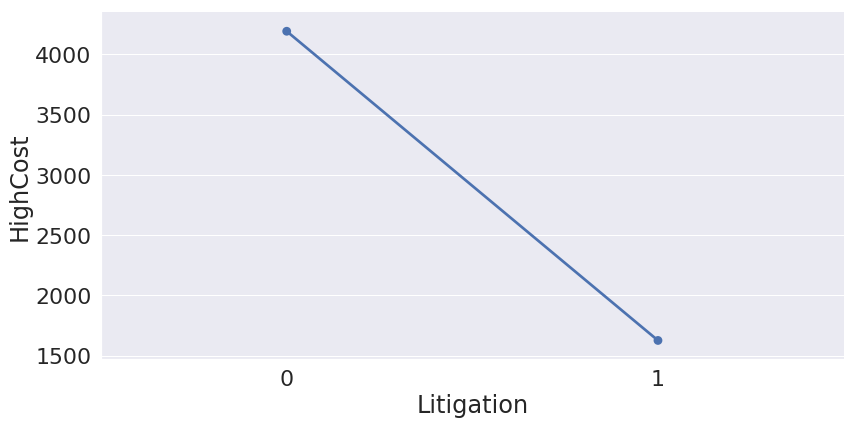

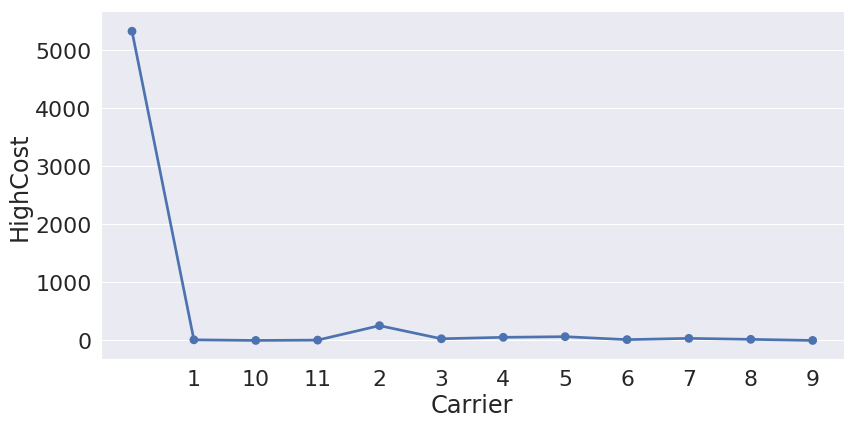

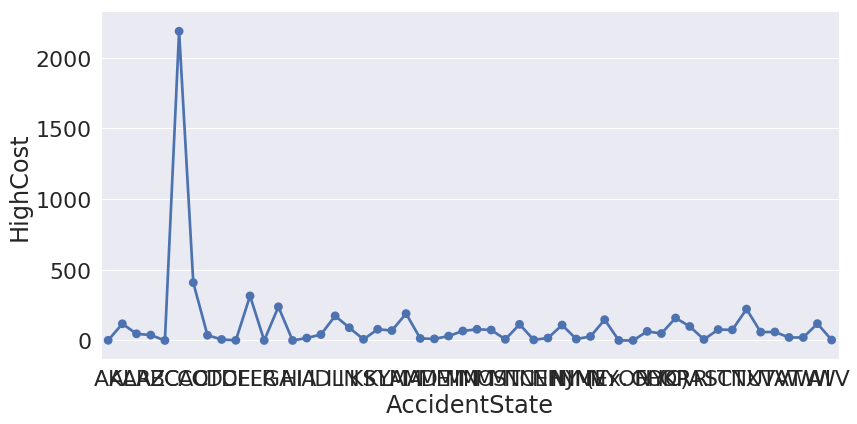

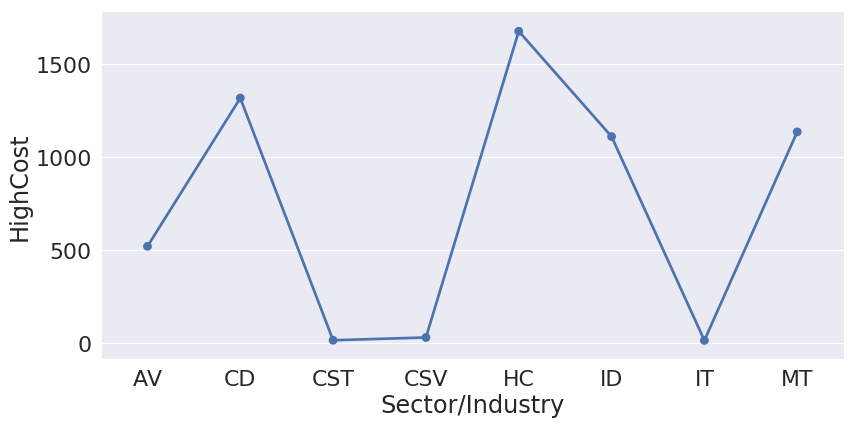

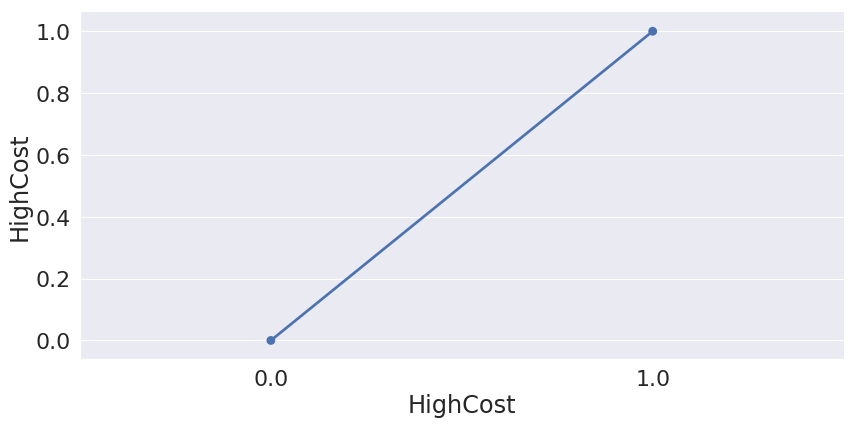

In [181]:
import seaborn as sns

# Bivariate Analysis of all categorical variables with Target Variable.
for col in categorical_variables:
    df_cat = pd.DataFrame(description_text.groupby([col], as_index=False).sum())
    sns.catplot(x=col, y="HighCost", data=df_cat.reset_index(), kind="point", height=6, aspect=2)

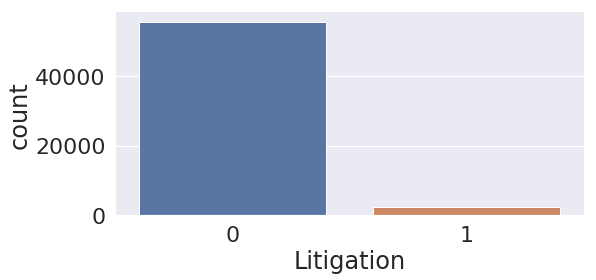

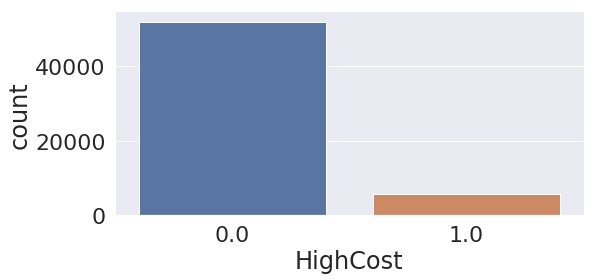

In [182]:
## Comparinson Between Litigation and HighCost
# factorplot for all categorical variables
for i in ['Litigation','HighCost']:
    sns.factorplot(data=description_text,x=i,kind='count',size=4,aspect=2)

In [183]:
#loop for ANOVA test Since the target variable is continuous
for i in ['Litigation','HighCost']:
    f, p = stats.f_oneway(description_text[i], numerical_df["ClaimCost"])
    print("P value for variable "+str(i)+" is "+str(p))
    
# Since P-Value of ANOVA test is less than 0.01, we can confidently say that 
# there's high correlation between Litigation and ClaimClost

P value for variable Litigation is 7.088441639291959e-200
P value for variable HighCost is 7.122165671865737e-200


In [184]:
# vectorization
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, min_df=0.001)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6, min_df=0.001)

In [185]:
# transform my predictors
cv_data = count_vectorizer.fit_transform(description_text.cleaned_description)
tfidf_data = tfidf_vectorizer.fit_transform(description_text.cleaned_description)

In [186]:
len(count_vectorizer.vocabulary_)

1730

In [187]:
len(tfidf_vectorizer.vocabulary_)

1730

In [188]:
cv_data.shape

(57749, 1730)

In [189]:
description_text.shape

(57749, 17)

In [190]:
numerical_columns = ['ClaimCost', 'LossDate', 'ClosedDate', 'ReportDate']

In [191]:
numerical_df = df[numerical_columns]

In [192]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57749 entries, 0 to 57748
Data columns (total 4 columns):
ClaimCost     57740 non-null float64
LossDate      57740 non-null float64
ClosedDate    44354 non-null object
ReportDate    50872 non-null object
dtypes: float64(2), object(2)
memory usage: 1.8+ MB


In [193]:
numerical_df['LossDate'] = numerical_df['LossDate'].fillna(int(numerical_df['LossDate'].mean()))

In [194]:
numerical_df['ReportDate'] = pd.to_numeric(numerical_df['ReportDate'], errors='coerce')
numerical_df['ReportDate'] = numerical_df['ReportDate'].fillna(int(numerical_df['ReportDate'].mean()))

In [195]:
numerical_df['ClaimCost'] = numerical_df.ClaimCost.fillna(numerical_df['ClaimCost'].mean())

In [196]:
from pyxlsb import convert_date
import math
f = lambda x : x if x is np.nan else convert_date(x)

numerical_df['LossDate'] = numerical_df['LossDate'].apply(f)
numerical_df['ReportDate'] = numerical_df['ReportDate'].apply(f)
numerical_df['ClosedDate'] = numerical_df['ClosedDate'].apply(f)

In [197]:
numerical_df.isnull().sum()

ClaimCost         0
LossDate          0
ClosedDate    15779
ReportDate        0
dtype: int64

In [198]:
def seasons(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

def week(x):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (x >=0) and (x <= 4):
        return 'weekday'
    elif (x >=5) and (x <=6 ):
        return 'weekend'

In [199]:
## Deriving new values like year, month, day_of_the_week, season, week from date

for col in numerical_df.columns:
    if col != "ClaimCost":
        #print("++++++++++++++++++ {} +++++++++++++++++++++".format(col))
        numerical_df[col+"_year"] = numerical_df[col].apply(lambda row: row.year)
        numerical_df[col+"_month"] = numerical_df[col].apply(lambda row: row.month)
        numerical_df[col+"_day_of_week"] = numerical_df[col].apply(lambda row: row.dayofweek)
        numerical_df[col+'_seasons'] = numerical_df[col+"_month"].apply(seasons)
        numerical_df[col+'_week'] = numerical_df[col+"_day_of_week"].apply(week)



In [200]:
# Create new variable which takes into account the difference between Date when loss occured and Incident Report Date

numerical_df['Diff_Days_Loss_Report'] = numerical_df['ReportDate'] - numerical_df['LossDate']
numerical_df['Diff_Days_Loss_Report'] = numerical_df['Diff_Days_Loss_Report']/np.timedelta64(1,'D')

In [201]:
numerical_df['Diff_Days_Loss_Closed'] = numerical_df['ClosedDate'] - numerical_df['LossDate']
numerical_df['Diff_Days_Loss_Closed'] = numerical_df['Diff_Days_Loss_Closed']/np.timedelta64(1,'D')

In [202]:
numerical_df['Diff_Days_Report_Closed'] = numerical_df['ClosedDate'] - numerical_df['ReportDate']
numerical_df['Diff_Days_Report_Closed'] = numerical_df['Diff_Days_Report_Closed']/np.timedelta64(1,'D')

In [203]:
# Drop Date Columns since we've extracted all possible information from them 
numerical_df = numerical_df.drop(['ClosedDate', 'ReportDate', 'LossDate'], axis = 1)

In [204]:
numerical_df.head()

,ClaimCost,LossDate_year,LossDate_month,LossDate_day_of_week,LossDate_seasons,LossDate_week,ClosedDate_year,ClosedDate_month,ClosedDate_day_of_week,ClosedDate_seasons,ClosedDate_week,ReportDate_year,ReportDate_month,ReportDate_day_of_week,ReportDate_seasons,ReportDate_week,Diff_Days_Loss_Report,Diff_Days_Loss_Closed,Diff_Days_Report_Closed
0,13491.900269,2016,9,2,fall,weekday,2016.0,11.0,2.0,fall,weekday,2016,10,0,fall,weekday,5.0,63.0,58.0
1,400921.536300,2016,9,4,fall,weekday,NaN,NaN,NaN,None,None,2016,10,1,fall,weekday,11.0,NaN,NaN
2,4886.505400,2017,1,1,winter,weekday,2018.0,1.0,5.0,winter,weekend,2017,3,3,spring,weekday,37.0,347.0,310.0
3,2506.715738,2016,11,1,fall,weekday,2017.0,2.0,1.0,winter,weekday,2016,12,4,winter,weekday,3.0,84.0,81.0
4,2916.488363,2016,7,4,summer,weekday,2017.0,2.0,5.0,winter,weekend,2016,7,4,summer,weekday,14.0,225.0,211.0


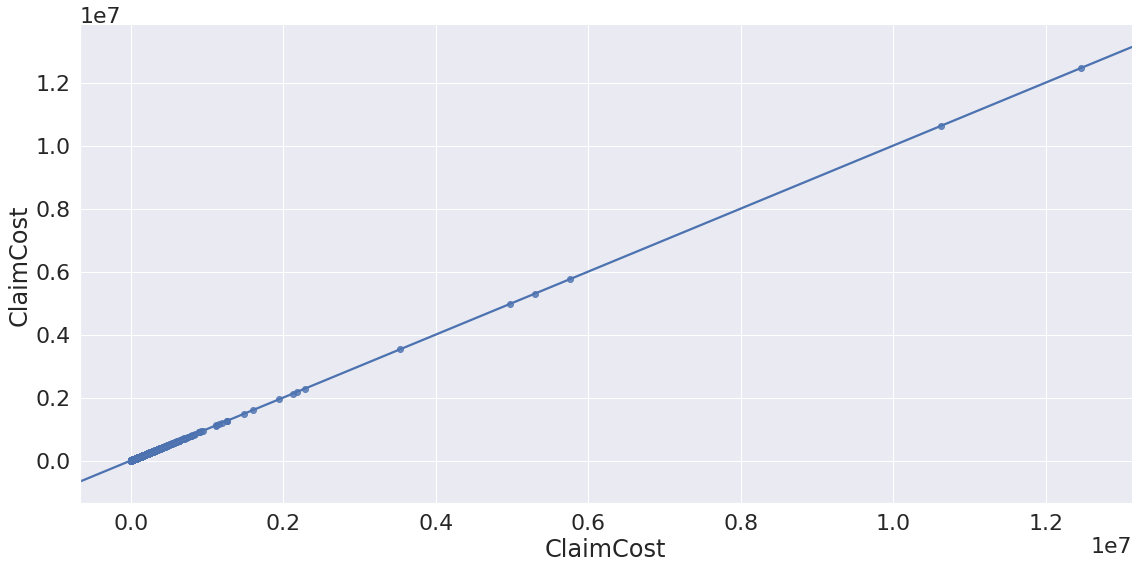

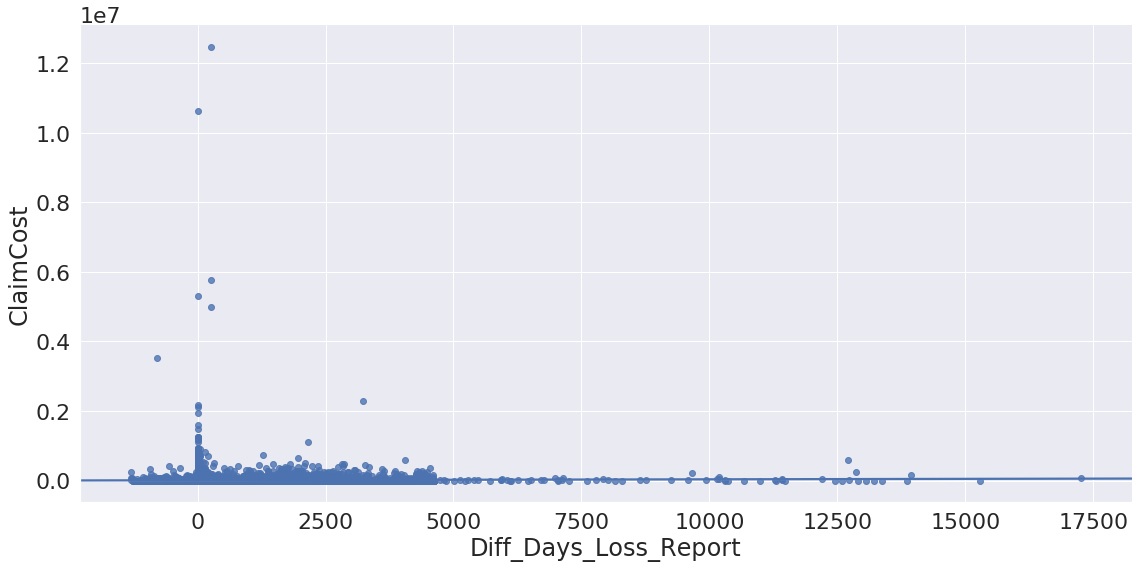

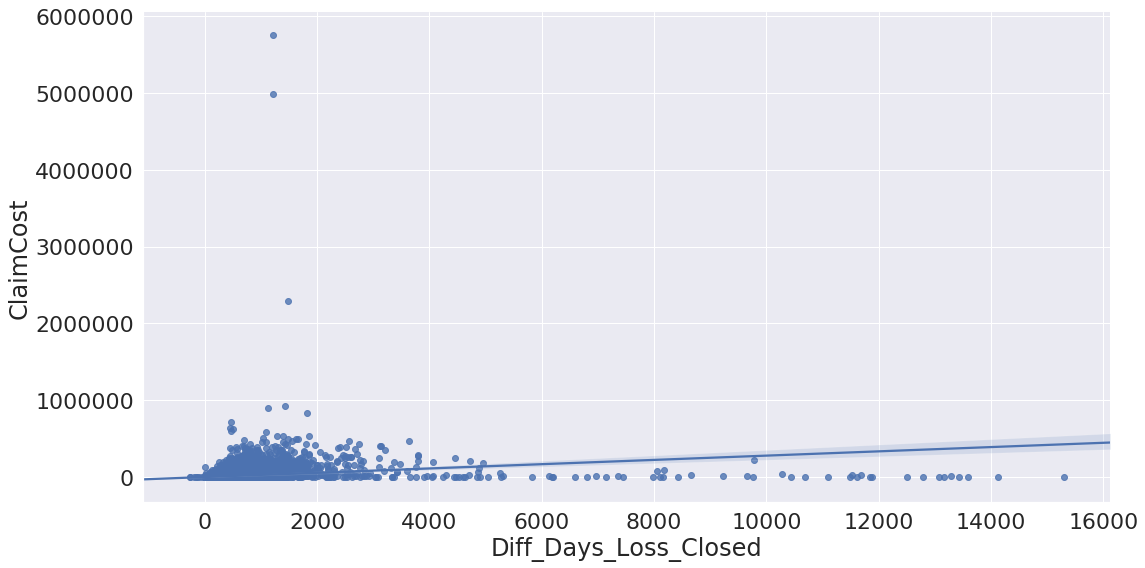

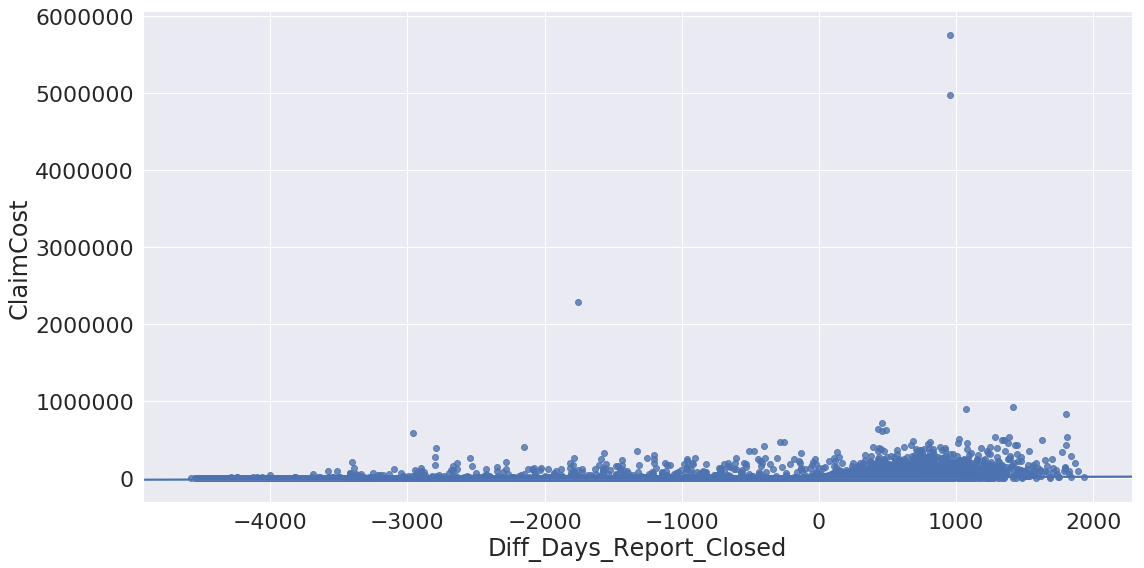

In [205]:
continous_column_names = ['ClaimCost', 'Diff_Days_Loss_Report', 'Diff_Days_Loss_Closed', 'Diff_Days_Report_Closed']

######################## Bivariate Analysis of Numerical Variables ################################
# Bivariate Analysis of all continous variables with Target Variable.
for i,col in enumerate(continous_column_names):
    sns.lmplot(x=col, y="ClaimCost", data=numerical_df, aspect=2, height=8)

In [206]:
description_text.shape

(57749, 17)

In [207]:
numerical_df.shape

(57749, 19)

In [208]:
categorical_variables.remove('Litigation')
categorical_variables.remove('HighCost')
categorical_variables

['LossType', 'Status_Updated', 'Carrier', 'AccidentState', 'Sector/Industry']

In [209]:
##################### One hot Encoding #####################
# Encoding Categorical Data
description_text_encoded = pd.get_dummies(data = description_text, columns = categorical_variables)


In [210]:
description_text_encoded.columns

Index(['CauseDescription', 'Litigation', 'HighCost', 'cleaned_description',
       'Desc_num_words', 'Desc_num_unique_words', 'Desc_num_chars',
       'Desc_num_stopwords', 'Desc_num_punctuations', 'Desc_num_words_upper',
       'Desc_num_words_CauseDescription', 'mean_word_len',
       'LossType_Indemnity', 'LossType_Medical Only', 'LossType_Notice Only',
       'LossType_Unknown', 'Status_Updated_0', 'Status_Updated_1', 'Carrier_',
       'Carrier_1', 'Carrier_10', 'Carrier_11', 'Carrier_2', 'Carrier_3',
       'Carrier_4', 'Carrier_5', 'Carrier_6', 'Carrier_7', 'Carrier_8',
       'Carrier_9', 'AccidentState_AK', 'AccidentState_AL', 'AccidentState_AR',
       'AccidentState_AZ', 'AccidentState_BC', 'AccidentState_CA',
       'AccidentState_CO', 'AccidentState_CT', 'AccidentState_DC',
       'AccidentState_DE', 'AccidentState_FL', 'AccidentState_FR',
       'AccidentState_GA', 'AccidentState_HI', 'AccidentState_IA',
       'AccidentState_ID', 'AccidentState_IL', 'AccidentState_IN',
 

In [211]:
##################### One hot Encoding #####################
# Encoding Categorical Data
numerical_df = pd.get_dummies(data = numerical_df, columns = ['LossDate_year', 'LossDate_month', 'LossDate_day_of_week',
       'LossDate_seasons', 'LossDate_week', 'ClosedDate_year',
       'ClosedDate_month', 'ClosedDate_day_of_week', 'ClosedDate_seasons',
       'ClosedDate_week', 'ReportDate_year', 'ReportDate_month',
       'ReportDate_day_of_week', 'ReportDate_seasons', 'ReportDate_week'])

In [212]:
numerical_df.columns

Index(['ClaimCost', 'Diff_Days_Loss_Report', 'Diff_Days_Loss_Closed',
       'Diff_Days_Report_Closed', 'LossDate_year_1966', 'LossDate_year_1973',
       'LossDate_year_1976', 'LossDate_year_1978', 'LossDate_year_1979',
       'LossDate_year_1980',
       ...
       'ReportDate_day_of_week_3', 'ReportDate_day_of_week_4',
       'ReportDate_day_of_week_5', 'ReportDate_day_of_week_6',
       'ReportDate_seasons_fall', 'ReportDate_seasons_spring',
       'ReportDate_seasons_summer', 'ReportDate_seasons_winter',
       'ReportDate_week_weekday', 'ReportDate_week_weekend'],
      dtype='object', length=148)

In [213]:
# combining both dataframes
full_df = pd.concat([description_text_encoded, numerical_df], axis=1)
full_df.head()

,CauseDescription,Litigation,HighCost,cleaned_description,Desc_num_words,Desc_num_unique_words,Desc_num_chars,Desc_num_stopwords,Desc_num_punctuations,Desc_num_words_upper,...,ReportDate_day_of_week_3,ReportDate_day_of_week_4,ReportDate_day_of_week_5,ReportDate_day_of_week_6,ReportDate_seasons_fall,ReportDate_seasons_spring,ReportDate_seasons_summer,ReportDate_seasons_winter,ReportDate_week_weekday,ReportDate_week_weekend
0,THE IW REPORTED HE WAS WALKING BACK TO FORK LI...,0,0.0,reported walking back fork lift felt pop right...,21,19,96,9,1,21,...,0,0,0,0,1,0,0,0,1,0
1,"IE WAS GETTING OFF A FORKLIFT, FOOT SLIPPED AN...",0,1.0,getting forklift foot slipped felt pain lower ...,15,15,74,6,1,15,...,0,0,0,0,1,0,0,0,1,0
2,"IW WAS WALKING AROUND A SHEETING MACHINE, WHEN...",0,0.0,walking around sheeting machine heard pop lft ...,29,24,142,9,4,29,...,1,0,0,0,0,1,0,0,1,0
3,"IW WAS HANDLING MATERIAL, CONFIRMING ORDER, IW...",0,0.0,handling material confirming order turned hit ...,16,15,85,4,3,15,...,0,1,0,0,0,0,0,1,1,0
4,IW GOT FIBER GLASS DEBRIS IN EYE,0,0.0,got fiber glass debris eye,7,7,32,1,0,7,...,0,1,0,0,0,0,1,0,1,0


In [214]:
# Combining Sentence Vectors to Complete Dataframe
count_vect_df = pd.DataFrame(cv_data.todense(), columns=count_vectorizer.get_feature_names())

In [215]:
tfidf_vect_df = pd.DataFrame(tfidf_data.todense(), columns=tfidf_vectorizer.get_feature_names())

In [216]:
full_df_with_count_vect = pd.concat([full_df, count_vect_df], axis=1)

In [217]:
full_df_with_tfidf_vect = pd.concat([full_df, tfidf_vect_df], axis=1)

In [218]:
full_df_with_count_vect.head(1)

,CauseDescription,Litigation,HighCost,cleaned_description,Desc_num_words,Desc_num_unique_words,Desc_num_chars,Desc_num_stopwords,Desc_num_punctuations,Desc_num_words_upper,...,wrist,wrist hand,wrist left,wrist pain,wrist right,wrist sprain,wrist strain,wrists,wrong,yesterday
0,THE IW REPORTED HE WAS WALKING BACK TO FORK LI...,0,0.0,reported walking back fork lift felt pop right...,21,19,96,9,1,21,...,0,0,0,0,0,0,0,0,0,0


In [219]:
full_df_with_count_vect.shape

(57749, 1968)

In [220]:
full_df_with_count_vect = full_df_with_count_vect.drop(['CauseDescription', 'cleaned_description'], axis=1)

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [222]:
#Creating dataframe with number of missing values
missing_val = pd.DataFrame(full_df_with_count_vect.isnull().sum())

#Reset the index to get row names as columns
missing_val = missing_val.reset_index()

#Rename the columns
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})

#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(full_df_with_count_vect))*100

#Sort the rows according to decreasing missing percentage
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)

#Save output to csv file
missing_val.to_csv("Missing_percentage.csv", index = False)

missing_val

,Variables,Missing_percentage
0,Diff_Days_Report_Closed,27.323417
1,Diff_Days_Loss_Closed,27.323417
2,mean_word_len,1.638124
3,Litigation,0.000000
4,piece,0.000000
5,placed,0.000000
6,place,0.000000
7,pit,0.000000
8,pipe,0.000000
9,pinky finger,0.000000


In [223]:
full_df_with_count_vect = full_df_with_count_vect.drop(['Diff_Days_Report_Closed', 'Diff_Days_Loss_Closed'],axis = 1)

In [224]:
full_df_with_count_vect['mean_word_len'] = full_df_with_count_vect['mean_word_len'].fillna(full_df_with_count_vect['mean_word_len'].mean())

In [225]:
########## Model for HighCost #############
######################## Model Building #####################
## Divide the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( full_df_with_count_vect.iloc[:, full_df_with_count_vect.columns != 'HighCost'], full_df_with_count_vect['HighCost'], test_size = 0.2, random_state = 1)

In [226]:
# import the ML algorithm
from sklearn.linear_model import LogisticRegression

# Instantiate the classifier
LogReg = LogisticRegression()

# Train classifier
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [227]:
# Do Prediction
y_pred = LogReg.predict(X_test)

In [228]:
# Confusion Matrix
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[10342,    28],
       [   37,  1143]])

In [229]:
print("Test set accuracy - ", metrics.accuracy_score(y_test, y_pred))
print("Train set accuracy - ", metrics.accuracy_score(y_train, LogReg.predict(X_train)))

Test set accuracy -  0.9943722943722944
Train set accuracy -  0.995151410203684


In [230]:
# Classification Report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10370
         1.0       0.98      0.97      0.97      1180

   micro avg       0.99      0.99      0.99     11550
   macro avg       0.99      0.98      0.98     11550
weighted avg       0.99      0.99      0.99     11550



In [231]:
# Apply RandomForest Classifier Algo
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [232]:
# Do Prediction
y_pred_rf = clf.predict(X_test)

In [233]:
# Confusion Matrix
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred_rf)

array([[10366,     4],
       [   14,  1166]])

In [234]:
print("Test set accuracy - ", metrics.accuracy_score(y_test, y_pred_rf))
print("Train set accuracy - ", metrics.accuracy_score(y_train, clf.predict(X_train)))

Test set accuracy -  0.9984415584415585
Train set accuracy -  1.0


In [235]:
# Classification Report
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10370
         1.0       1.00      0.99      0.99      1180

   micro avg       1.00      1.00      1.00     11550
   macro avg       1.00      0.99      1.00     11550
weighted avg       1.00      1.00      1.00     11550



In [236]:
#### Achieved almots 100% accuracy on Test as well as Train Dataset for Model which Predicts HighCost

In [237]:
######### Model for Litigation #########

In [238]:
######################## Model Building #####################
## Divide the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( full_df_with_count_vect.iloc[:, full_df_with_count_vect.columns != 'Litigation'], full_df_with_count_vect['Litigation'], test_size = 0.2, random_state = 1)

In [239]:
# import the ML algorithm
from sklearn.linear_model import LogisticRegression

# Instantiate the classifier
LogReg = LogisticRegression()

# Train classifier
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [240]:
# Do Prediction
y_pred = LogReg.predict(X_test)

In [241]:
# Confusion Matrix
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[11004,    59],
       [  349,   138]])

In [242]:
print("Test set accuracy - ", metrics.accuracy_score(y_test, y_pred))
print("Train set accuracy - ", metrics.accuracy_score(y_train, LogReg.predict(X_train)))

Test set accuracy -  0.9646753246753247
Train set accuracy -  0.9666659451503279


In [243]:
# Classification Report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11063
           1       0.70      0.28      0.40       487

   micro avg       0.96      0.96      0.96     11550
   macro avg       0.83      0.64      0.69     11550
weighted avg       0.96      0.96      0.96     11550



In [244]:
# Apply RandomForest Classifier Algo
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [245]:
# Do Prediction
y_pred_rf = clf.predict(X_test)

In [246]:
# Confusion Matrix
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred_rf)

array([[11053,    10],
       [  419,    68]])

In [247]:
print("Test set accuracy - ", metrics.accuracy_score(y_test, y_pred_rf))
print("Train set accuracy - ", metrics.accuracy_score(y_train, clf.predict(X_train)))

Test set accuracy -  0.9628571428571429
Train set accuracy -  1.0


In [248]:
# Classification Report
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     11063
           1       0.87      0.14      0.24       487

   micro avg       0.96      0.96      0.96     11550
   macro avg       0.92      0.57      0.61     11550
weighted avg       0.96      0.96      0.95     11550



In [249]:
#### Conclsuion : 

#1) Built a model to predict high cost workers compnesation claim with almost 100% Testing Accuracy
#2) Built a model to predict whether a claim will go for litigation or not with almost 96% Testing Accuracy
#3) Explored through Exploratory Data Analysis and understood the relationship of features.
#4) Built Wordcloud to better understand what are the TOP MOST Employee reasons for claiming.
#5) Proved that litigation is the key driver of high cost claims using statistical analysis (ANOVA) and graphs.
#6) Did alot of Feaure Engineering and built new features to assist the model to better understand the patterns inside the data:
    #1) Dervied new features Like Year, Month, Season from Variables including Date (Report, Loss, Closed Date)
    #2) Reshaped the entire dataset from 16 columns to 1968 columns with same rows.
    #3) Applied Textual Preprocessing and cleaning techniques to create features from CauseDescription Sentences
    #4) Using NLP - Bag of Words (Count/TF IDF Vectorizer) Transformed CauseDescription Sentences to Vector Representations
    